### MSDS OOP WITH PYTHON Assignment 1 

**Author:** Muganga Charles <br />
**Access No.:** B35391  <br />
**Reg No:** S25M19/026


### Setting up <a id="Setup"></a>

Importing commonly used packages.


In [1]:
import math
import pandas as pd
import statistics as stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve as linsolve

### Question 1: UBOS multi district population & growth forecast <a id="Q1"></a>

**Given the dataset:**  
- Kampala = `[1200, 1250, 1300, 1350, 1420, 1500, 1580, 1650, 1720, 1800]`  
- Wakiso  = `[950, 1000, 1070, 1150, 1220, 1300, 1390, 1480, 1570, 1670]`  
- Gulu    = `[320, 330, 345, 360, 375, 390, 410, 430, 455, 480]`

**Tasks:**  


##### 1.1. Storing each district’s data in Numpy arrays. 

In [2]:
kampala = np.array([1200, 1250, 1300, 1350, 1420, 1500, 1580, 1650, 1720, 1800], dtype=float)
wakiso  = np.array([ 950, 1000, 1070, 1150, 1220, 1300, 1390, 1480, 1570, 1670], dtype=float)
gulu    = np.array([ 320,  330,  345,  360,  375,  390,  410,  430,  455,  480], dtype=float)

districts = {"Kampala": kampala, "Wakiso": wakiso, "Gulu": gulu}

##### 1.2. Computation of mean, median, variance, and standard deviation using the `statistics` module. 

In [3]:
def describe(arr):
    return {
        "mean": stats.mean(arr),
        "median": stats.median(arr),
        "variance": stats.pvariance(arr),  
        "std_dev": stats.pstdev(arr)       
    }

summary = {name: describe(arr) for name, arr in districts.items()}
summary_df = pd.DataFrame.from_dict(summary, orient="index").reset_index()
summary_df = summary_df.rename(columns={"index": "District"})
summary_df = summary_df[["District", "mean", "median", "variance", "std_dev"]].round(2)

summary_df

,District,mean,median,variance,std_dev
0,Kampala,1477.0,1460.0,38341.00,195.81
1,Wakiso,1280.0,1260.0,54060.00,232.51
2,Gulu,389.5,382.5,2597.25,50.96


The table above shows central tendency and dispersion for each district’s population estimates.  
- I used **population** variance/std (pvariance/pstdev) because the 10‑year series is treated as the full population of interest for this task.


##### 1.3. Generating a **Fibonacci** sequence of length 5 to project the next 5 years’ growth.

In [4]:
## Helper function to generate Fibonacci numbers
def fibonacci(number):
    """ 
    the function is supposed to return a list with 
    the first n(number) Fibonacci numbers starting with [1, 1, ...]
    """
    if number <= 0:
        return []
    if number == 1:
        return [1]
    fib = [1, 1]
    for _ in range(2, number):
        fib.append(fib[-1] + fib[-2])
    return fib

In [5]:
fib5 = np.array(fibonacci(5), dtype=float)
fib5


array([1., 1., 2., 3., 5.])

**Projection methodology:**  
I will scale the last observed value for each district by relative Fibonacci weights to create a simple growth projection.  
Let the weights be `w = fib5 / sum(fib5)`. Then the projected increments over 5 years sum to, say, **10%** of the last observed value.

In [6]:
## creating a normalized fibonacci weight vector
weight = fib5 / fib5.sum()

In [36]:
## getting a modest aggregate growth factor over 5 years.
aggregate_growth_pct = 0.10  ##a 10% total growth distributed by Fibonacci weights

projections = {}
for name, arr in districts.items():
    last = arr[-1]
    increments = last * aggregate_growth_pct * weight 
    projected = last + np.cumsum(increments)
    projections[name] = projected

projections_df = pd.DataFrame(projections, index=[f'Year {i+1}' for i in range(len(weight))])
projections_df.round(2)

,Kampala,Wakiso,Gulu
Year 1,1815.0,1683.92,484.0
Year 2,1830.0,1697.83,488.0
Year 3,1860.0,1725.67,496.0
Year 4,1905.0,1767.42,508.0
Year 5,1980.0,1837.00,528.0


##### 1.4. Comparing the variance of **actual vs projected** data. 

In [39]:
variance_comparison = {}
for name, arr in districts.items():
    actual_variance = stats.pvariance(arr)
    projected_variance   = stats.pvariance(np.concatenate([arr[-1:], projections[name]]))  
    variance_comparison[name] = {"actual_variance": actual_variance, "projected_variance": projected_variance}

variance_df = pd.DataFrame(variance_comparison).T 
variance_df.round(2)

,actual_variance,projected_variance
Kampala,38341.00,3800.00
Wakiso,54060.00,3270.93
Gulu,2597.25,270.22


##### 1.5 Plot actual vs projected populations for each district 

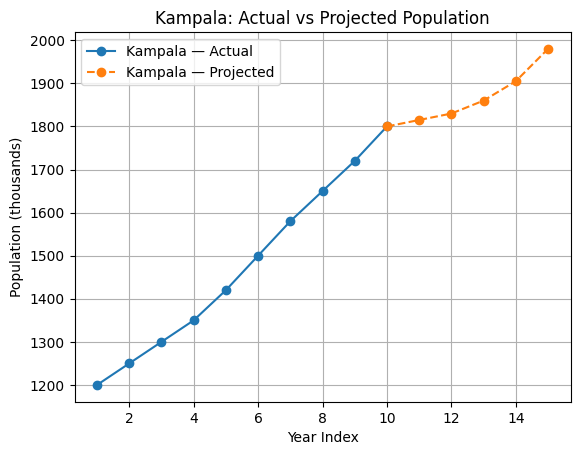

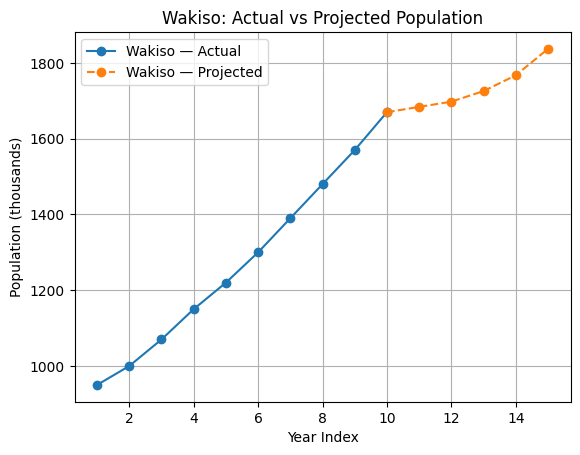

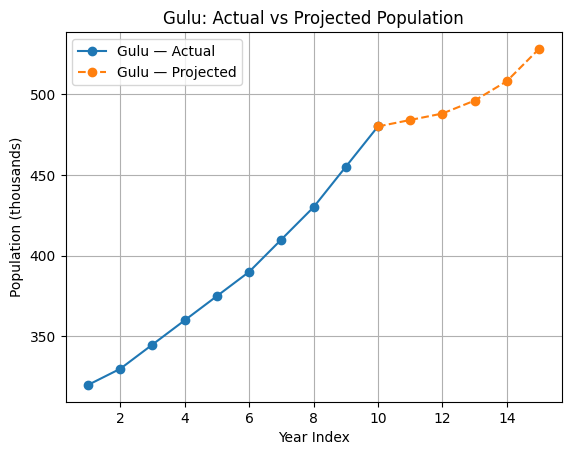

In [9]:
years_actual = np.arange(1, len(kampala) + 1)
years_projected   = np.arange(len(kampala), len(kampala) + len(projections["Kampala"]) + 1)

for name, actual in districts.items():
    projected = projections[name]
    plt.figure()
    plt.plot(years_actual, actual, marker='o', label=f"{name} — Actual")
    plt.plot(years_projected,    np.concatenate([[actual[-1]], projected]), marker='o', linestyle='--', label=f"{name} — Projected")
    plt.title(f"{name}: Actual vs Projected Population")
    plt.xlabel("Year Index")
    plt.ylabel("Population (thousands)")
    plt.legend()
    plt.grid(True)
    plt.show()

### Question 2: Solar micro grid simulation <a id="Q2"></a>

**the provided equations:**  
3x + 2y = D1, and 4x + y = D2
where **x = solar panels** and **y = batteries**.

#### 2.1 Prompting a user input and store daily demand values

In [10]:
demands = []
for day in range(1, 8):
    D1 = float(input(f"Enter D1 for day {day}: "))
    D2 = float(input(f"Enter D2 for day {day}: "))
    demands.append([D1, D2])
demands = np.array(demands, dtype=float)

In [41]:
### defining the coefficient matrix
A = np.array([[3.0, 2.0],
              [4.0, 1.0]], dtype=float)

### solving the equations for each day's demands
solutions = []  

for D1, D2 in demands:
    b = np.array([D1, D2], dtype=float)
    x_y = linsolve(A, b)
    solutions.append(x_y)

solutions = np.array(solutions)
solutions_df = pd.DataFrame(solutions, columns=['Solar (x)', 'Battery (y)'])
solutions_df.index = solutions_df.index + 1  
solutions_df.index.name = 'Day'

solutions_df

,Solar (x),Battery (y)
Day,,
1,203.4,-257.6
2,2.4,23.4
3,111.4,110.4
4,12.8,-17.2
5,89.4,87.4
6,-64.4,313.6
7,19.0,10.0


#### 2.4 Descriptive statistics for solar vs battery usage across 7 days

In [43]:
solar   = solutions[:, 0]
battery = solutions[:, 1]

stats_summary_q2 = {
    "solar": {
        "mean": stats.mean(solar),
        "variance": stats.pvariance(solar),
        "std_dev": stats.pstdev(solar)
    },
    "battery": {
        "mean": stats.mean(battery),
        "variance": stats.pvariance(battery),
        "std_dev": stats.pstdev(battery)
    }
}
stats_df = pd.DataFrame(stats_summary_q2).T  
stats_df.round(2)

,mean,variance,std_dev
solar,53.43,6638.51,81.48
battery,38.57,25008.39,158.14


#### 2.5 Plot daily solar vs battery usage 

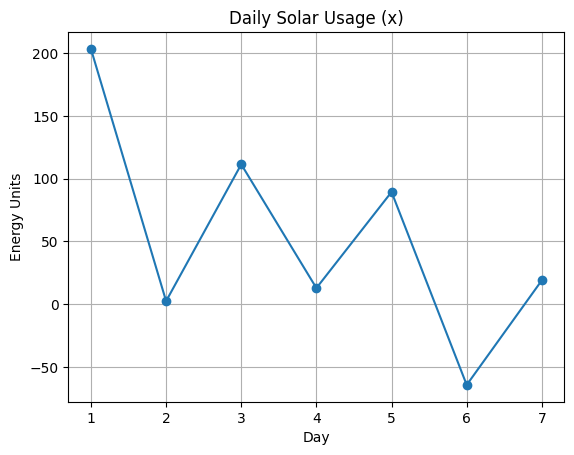

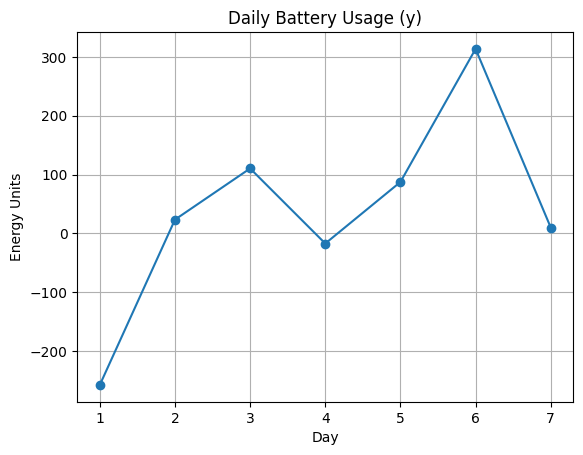

In [13]:

days = np.arange(1, len(solutions) + 1)

plt.figure()
plt.plot(days, solar, marker='o')
plt.title("Daily Solar Usage (x)")
plt.xlabel("Day")
plt.ylabel("Energy Units")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(days, battery, marker='o')
plt.title("Daily Battery Usage (y)")
plt.xlabel("Day")
plt.ylabel("Energy Units")
plt.grid(True)
plt.show()


### Question 3: Lake Victoria Fish Export Risk Model <a id="Q3"></a>

#### 3.1 Generating 15 Fibonacci numbers to simulate fish stock growth.  

In [14]:
stock_raw = np.array(fibonacci(15), dtype=float)
stock = stock_raw * 10.0 #multiplying by 10 to represent kg units per period

#### 3.2 Simulating prices (UGX per kg)

In [15]:
prices = np.array([12000, 12500, 11800, 13000, 12800, 12700, 13100, 12900, 12600, 13200, 13300, 13150, 12950, 13050, 12850], dtype=float)
prices

array([12000., 12500., 11800., 13000., 12800., 12700., 13100., 12900.,
       12600., 13200., 13300., 13150., 12950., 13050., 12850.])

#### 3.3 Computing daily revenue by  **revenue = stock × price**. 

In [16]:
revenue = stock * prices

#### 3.4 Calculating Summary statistics

In [17]:
revenue_mean = stats.mean(revenue)
revenue_median = stats.median(revenue)
revenue_variance = stats.pvariance(revenue)
print(f"Mean :{revenue_mean:.3f}\nMedian : {revenue_median}\nVariance : {revenue_variance}")

Mean :13800866.667
Median : 2709000.0
Variance : 479989827082222.25


#### 3.5 Risk classification

In [46]:
risk = "High risk" if revenue_variance > 50000 else "Low risk"

revenue_summary = {
    "revenue_mean": revenue_mean,
    "revenue_median": revenue_median,
    "revenue_variance": revenue_variance,
    "risk": risk
}
revenue_df = pd.DataFrame([revenue_summary]) 
revenue_df

,revenue_mean,revenue_median,revenue_variance,risk
0,1.380087e+07,2709000.0,4.799898e+14,High risk


#### 3.6 Visualization of  stock and revenue

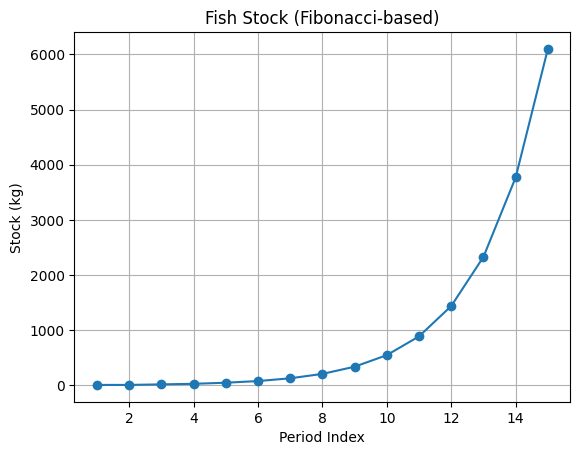

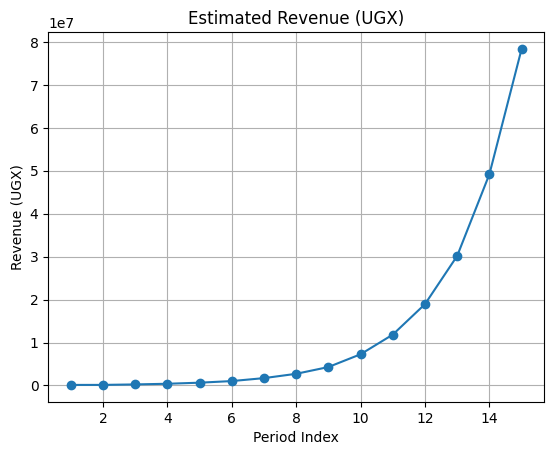

In [19]:

periods = np.arange(1, len(stock) + 1)

plt.figure()
plt.plot(periods, stock, marker='o')
plt.title("Fish Stock (Fibonacci-based)")
plt.xlabel("Period Index")
plt.ylabel("Stock (kg)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(periods, revenue, marker='o')
plt.title("Estimated Revenue (UGX)")
plt.xlabel("Period Index")
plt.ylabel("Revenue (UGX)")
plt.grid(True)
plt.show()


### Question 4: Weather & Agriculture Analysis <a id="Q4"></a>

**Kampala rainfall (mm) across 12 months:**  
`[120, 140, 180, 200, 220, 180, 90, 70, 60, 100, 110, 130]`

#### 4.1 Storing rainfall in a NumPy array.

In [20]:
kampala_rainfall = np.array([120, 140, 180, 200, 220, 180, 90, 70, 60, 100, 110, 130], dtype=float)

#### 4.2 Computing mean rainfall and classify months as `'Good for maize'` (>150 mm) or `'Drought risk'` (<150 mm).

In [21]:
kampala_mean = stats.mean(kampala_rainfall)

classification = ["Good for maize" if v > 150 else "Drought risk" for v in kampala_rainfall]

kampala_mean, classification

(np.float64(133.33333333333334),
 ['Drought risk',
  'Drought risk',
  'Good for maize',
  'Good for maize',
  'Good for maize',
  'Good for maize',
  'Drought risk',
  'Drought risk',
  'Drought risk',
  'Drought risk',
  'Drought risk',
  'Drought risk'])

####  4.3 Simulating **Gulu** rainfall with different values.

In [22]:
gulu_rainfall = np.array([110, 135, 170, 195, 210, 175, 85, 65, 75, 95, 105, 140], dtype=float)

#### 4.4 Cosine similarity of Kampala vs Gulu rainfall **using `math.cos()`**.

In [23]:
dot = float(np.dot(kampala_rainfall, gulu_rainfall))
norms = float(np.linalg.norm(kampala_rainfall) * np.linalg.norm(gulu_rainfall))
cosine_similarity = dot / norms if norms != 0 else float('nan')


- Demonstrating math.cos by converting similarity -> angle -> cos(angle)

In [24]:
angle = math.acos(max(min(cosine_similarity, 1.0), -1.0))  ## clamping due to floating-point
cosine_via_math = math.cos(angle)

cosine_similarity, cosine_via_math

(0.9987499696797129, 0.9987499696797129)

#### 4.5 Plotting Kampala & Gulu rainfall together

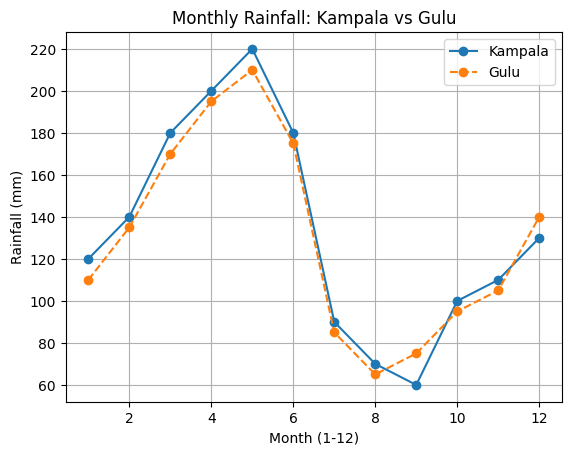

In [25]:
months = np.arange(1, 13)

plt.figure()
plt.plot(months, kampala_rainfall, marker='o', label='Kampala')
plt.plot(months, gulu_rainfall, marker='o', linestyle='--', label='Gulu')
plt.title("Monthly Rainfall: Kampala vs Gulu")
plt.xlabel("Month (1-12)")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.show()


### Question 5: Taxi Transport Revenue & Variability <a id="Q5"></a>

**Passenger counts for 10 days (Kampala–Ntinda) route:**  
`[35, 40, 42, 50, 55, 60, 48, 52, 47, 45]`


#### 5.1 Storing passenger counts in a NumPy array.

In [26]:
counts = np.array([35, 40, 42, 50, 55, 60, 48, 52, 47, 45], dtype=float)

#### 5.2 Computing daily revenue at  UGX 2000 per passenger.

In [27]:
fare = 2000.0  ##UGX per passenger
revenue = counts * fare

#### 5.3 Analyzing revenue using `statistics`.

In [49]:
revenue_stats = {
    "mean": stats.mean(revenue),
    "variance": stats.pvariance(revenue),
    "std_dev": stats.pstdev(revenue)
}

revenue_stats_df = pd.DataFrame([revenue_stats]) 
revenue_stats_df

,mean,variance,std_dev
0,94800.0,195360000.0,13977.124168


#### 5.4 Supply–Demand System
Let \(s\) be **supply capacity factor** and \(p\) be **pricing factor**. <br /> Suppose on a given day we model:

2s + p = C_1, <br /> s + 3p = C_2 

Here, C_1, C_2 are derived from observed counts and baseline pricing.  
We solve this 2×2 system via linear algebra to estimate \(s, p\).

In [29]:
C1 = counts[-1] * 0.8   
C2 = counts[-1] * 1.2

A = np.array([[2.0, 1.0],
              [1.0, 3.0]], dtype=float)
b = np.array([C1, C2], dtype=float)

s, p = linsolve(A, b)
s, p

(np.float64(10.799999999999999), np.float64(14.4))

#### 5.5 Forecasting 11th day revenue using average of last 3 days

In [30]:
last3 = counts[-3:]
forecast_count_day11 = stats.mean(last3)
forecast_revenue_day11 = forecast_count_day11 * fare
forecast_count_day11, forecast_revenue_day11

(np.float64(48.0), np.float64(96000.0))

### 5.6 Plotting actual revenues (days 1-10) and forecast for day 11

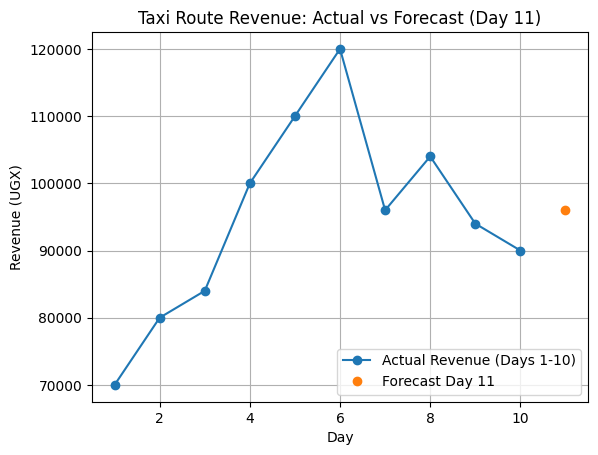

In [31]:
days = np.arange(1, len(revenue) + 1)
plt.figure()
plt.plot(days, revenue, marker='o', label='Actual Revenue (Days 1-10)')

## appending forecast as day 11
plt.plot([11], [forecast_revenue_day11], marker='o', linestyle='none', label='Forecast Day 11')

plt.title("Taxi Route Revenue: Actual vs Forecast (Day 11)")
plt.xlabel("Day")
plt.ylabel("Revenue (UGX)")
plt.legend()
plt.grid(True)
plt.show()